# Implement Word2Vec in Old Code

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.preprocessing.sequence import skipgrams

ModuleNotFoundError: No module named 'gensim'

In [2]:
data = pd.read_csv("../core/data/tweet_global_warming.csv", encoding="latin")
print("Full dataset: {}".format(data.shape[0]))
data['existence'].fillna(value='ambiguous', inplace = True) #replace NA's in existence with "ambiguous"
data['existence'].replace(('Y', 'N'), ('Yes', 'No'), inplace=True) #rename so encoder doesnt get confused
data = data.dropna() #now drop NA values
print("dataset without NaN: {}".format(data.shape[0]))
X = data.iloc[:,0]
Y = data.iloc[:,1]
print("Number of unique words: {}".format(len(np.unique(np.hstack(X)))))

#one hot encoding = dummy vars from categorical var 
#Create a one-hot encoded binary matrix 
#N, Y, Ambig
#1, 0, 0 
#0, 1, 0
#0, 0, 1

#encode class as integers 
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y) 

#convert integers to one hot encoded
Y = np_utils.to_categorical(encoded_Y)

Full dataset: 6090
dataset without NaN: 6087
Number of unique words: 5541


In [3]:
data.head() #check head

,tweet,existence,existence.confidence
0,Global warming report urges governments to act...,Yes,1.0000
1,Fighting poverty and global warming in Africa ...,Yes,1.0000
2,Carbon offsets: How a Vatican forest failed to...,Yes,0.8786
3,Carbon offsets: How a Vatican forest failed to...,Yes,1.0000
4,URUGUAY: Tools Needed for Those Most Vulnerabl...,Yes,0.8087


In [4]:
#one hot example
print("Ambiguous data point: ")
print (data.iloc[6083])
print ("One hot coding for ambiguous: {}".format(Y[6083]))

Ambiguous data point: 
tweet                   Virginia to Investigate Global Warming Scienti...
existence                                                       ambiguous
existence.confidence                                                    1
Name: 6086, dtype: object
One hot coding for ambiguous: [ 0.  0.  1.]


average tweet length: 
111 characters


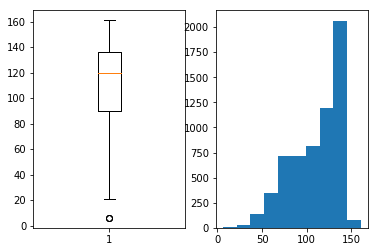

In [5]:
# Summarize review length
print("average tweet length: ")
result = list(map(len, X))
print("{:.0f}".format(np.mean(list(map(len, X)))), 'characters')
plt.subplot(121)
plt.boxplot(result)
plt.subplot(122)
plt.hist(result, bins=10)
plt.show()

In [6]:
print ("Training data: ")
print ("X: ", X.shape,"Y: ", Y.shape)
print ("Classes: ", np.unique(Y))
print("Number of unique words: ", len(np.unique(np.hstack(X)))) #based on encoding this is the number of unique words? Categorized by frequency 

# Summarize review length
print("Tweet length: ")
print("Mean %.0f words (std: %.2f)" % (np.mean(result), np.std(result)))

Training data: 
X:  (6087,) Y:  (6087, 3)
Classes:  [ 0.  1.]
Number of unique words:  5541
Tweet length: 
Mean 111 words (std: 27.51)


# Start Word2Vec Stuff
### First some dataset exploration
* Most of this is just leftover from when I accidently started coding up Word2Vec lolz

In [11]:
def read_data(data_file):
    for i, line in enumerate (data_file): 
        # do some pre-processing and return a list of words for each review text
        yield gensim.utils.simple_preprocess (line)

In [12]:
data_file="../core/data/tweet_global_warming.csv"
vocab = list(read_data(data['tweet']))
flat_vocab = [item for sublist in vocab for item in sublist] #need to flatten vocab list - couldnt figure out how to do with split 
#print (vocab[0:10]) #list of lists - bad 
print (flat_vocab[0:10]) #check that we have a single list of words - wahoo! 

['global', 'warming', 'report', 'urges', 'governments', 'to', 'act', 'brussels', 'belgium', 'ap']


In [13]:
def build_dataset(vocab, n_words):
    """Process the top n_words from raw inputs (vocab from read_data) into a dataset."""
    count = [['UNK', -1]] #stores when word is found --> UNK = unknown 
    count.extend(collections.Counter(vocab).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    token = list() 
    unk_count = 0
    for word in vocab: #
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK'] assigned to 0 
            unk_count += 1
        token.append(index) #outputs a list of integers that represent words
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys())) #allows for word lookup by integer
    return token, count, dictionary, reversed_dictionary

In [17]:
top_words = 20000 #use number higher than expected unique words 
token, count, dictionary, reversed_dictionary = build_dataset(flat_vocab, top_words) #check to see if runs on flat_vocab

In [18]:
len(dictionary) #check num unique words

12117

In [21]:
count[0:10] #number of times first 11 words are used, 

#UNK = unknown words to dict, should be zero when top_words > max words in dataset

[['UNK', 0],
 ('http', 3943),
 ('climate', 3757),
 ('change', 3438),
 ('global', 3244),
 ('warming', 3134),
 ('the', 2473),
 ('ly', 2401),
 ('bit', 2204),
 ('to', 1924)]

In [22]:
data['tweet'].head()

0    Global warming report urges governments to act...
1    Fighting poverty and global warming in Africa ...
2    Carbon offsets: How a Vatican forest failed to...
3    Carbon offsets: How a Vatican forest failed to...
4    URUGUAY: Tools Needed for Those Most Vulnerabl...
Name: tweet, dtype: object

## Now lets train a Word2Vec Model 

In [46]:
text = list(read_data(data['tweet'])) #create a list of words in tweets 
#text

In [85]:
#inputs 
#text = list of words 
#size = size of word vector **scaled from example that used 150 for a 18,000 word dataset**
#window = max distance between target word and nearest word 
#min_count = min times a word must appear in data set (weeds out infrequent words)
#sg=0, CBOW Training (best output)

model = gensim.models.Word2Vec (text, size=50, window=10, min_count=2, sg=0)

In [88]:
#######OTHER MODELS TO CONSIDER########
# we can also use gensims model.phrases module 
#bigram_transformer = gensim.models.Phrases(text)
#model = Word2Vec(bigram_transformer[text], size=50, window=10, min_count=2)

#or we could try using FastText another gensim model 
#FastText can be used on words not in dataset (unlike Word2Vec)
#from gensim.models import FastText
#model = FastText(text, size=100, window=5, min_count=5, workers=4)

In [87]:
word_vectors = model.wv #store word vectors 
#word_vectors.vocab #dict of words 
print (word_vectors.vocab['global']) #example of stored in dict
print (model.wv['global']) #example word vector 

Vocab(count:3244, index:3, sample_int:872712862)
[ 1.04918456  0.15850732 -1.40685773 -0.84766501 -0.87204534  0.57584053
 -0.1454823  -0.43417612 -0.41027182 -1.5447973  -0.32138428  0.97522813
 -0.67647725 -1.83529782 -0.51812011 -0.63785952  0.69422477  2.40389371
  0.727458    0.69882929  1.50972807 -1.54841352 -0.6773392  -0.83626193
  1.1212157   0.97462237  0.0263989  -2.44981337 -1.74876153  1.59723997
  1.52616787 -0.07044011 -0.12189162  0.4257499   0.6161328   0.16896611
  0.94026756  0.36409599  0.41795141  0.36264929  0.45958728 -2.36621046
 -0.07958051  1.52549458 -0.13357019  0.32000992  0.70338446 -0.73206228
  0.80231112 -0.39504412]


In [83]:
#can do some cool NLP tasks

model.wv.most_similar('global') #words most similar to global...lol

[('warming', 0.9966424107551575),
 ('then', 0.9962437152862549),
 ('or', 0.9961068630218506),
 ('all', 0.9957795143127441),
 ('you', 0.9957417249679565),
 ('if', 0.9957247376441956),
 ('heavily', 0.9946765899658203),
 ('believe', 0.994510293006897),
 ('snow', 0.9944669604301453),
 ('it', 0.994449257850647)]

In [84]:
model.wv.doesnt_match("global warming is dangerous".split()) #lol fun 2 play with 

'dangerous'

In [70]:
model.wv.similarity('global', 'warming') #solid for not using "phrases" model

0.99664246635732945

## Now feed Word2Vec Embeddings into Model? 
--> Cant figure out yet, ignore this section haha <--

In [71]:
top_words = 1000
max_words = 150
word_vec = 32 #dont understand why we want a 32 bit vector
test_split = 0.3

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=test_split)

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# create the model
model = Sequential()
model.add(Embedding(top_words+1, word_vec, input_length=max_words)) #is it better to preconvert using word to vec? 
model.add(Convolution1D(filters=word_vec, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(3, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model.summary())

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128,
    verbose=1)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

ValueError: invalid literal for int() with base 10: 'Ocean Saltiness Getting Weird ¥Ë_ Blame Global Warming: IndyPosted (blog) A study conducted by scientists at Austral... http://bit.ly/cCQa1y'